In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import datetime
import ccxt
import pybithumb
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

from tpot import TPOTClassifier, TPOTRegressor
from sklearn.model_selection import train_test_split

/root/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
# binance
binance = ccxt.binance()
ohlcv = binance.fetch_ohlcv("BTC/USDT", "6h")

sample = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
sample['datetime'] = pd.to_datetime(sample['datetime'], unit='ms')
sample.set_index('datetime', inplace=True)

In [3]:
tweets = pd.read_csv("tweets_count.csv", encoding="utf-8")
tweets["datetime"] = tweets["date_date"]
tweets.set_index('datetime', inplace=True)
tweets = tweets[["600", "1200", "1800", "2400"]]
tweets.head()



,600,1200,1800,2400
datetime,,,,
2021-02-05,0,99,907,688
2021-02-06,616,809,1066,787
2021-02-07,616,754,955,705
2021-02-08,505,689,2793,1660
2021-02-09,1164,1132,1178,876


In [4]:
sample['tweets'] = 0
for idx in tweets.index:
    dates = idx.split("-")
    dates = [int(x) for x in dates]
    pd_0to6 = pd.Timestamp(dates[0], dates[1], dates[2], 0, 0, 0)
    pd_6to12 = pd.Timestamp(dates[0], dates[1], dates[2], 6, 0, 0)
    pd_12to18 = pd.Timestamp(dates[0], dates[1], dates[2], 12, 0, 0)
    pd_18to24 = pd.Timestamp(dates[0], dates[1], dates[2], 18, 0, 0)

    sample.loc[pd_0to6, 'tweets'] = tweets.loc[idx, '600']
    sample.loc[pd_6to12, 'tweets'] = tweets.loc[idx, '1200']
    sample.loc[pd_12to18, 'tweets'] = tweets.loc[idx, '1800']
    sample.loc[pd_18to24, 'tweets'] = tweets.loc[idx, '2400']

In [5]:
# Use 10 frame for min and max
sample['number'] = sample.index.map(mdates.date2num)
sample['momentum'] = (sample['close'] - sample['close'].shift(10)) / sample['close'].shift(10)
sample['w_open'] = (sample['open'] - sample.rolling(window=10)['open'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_high'] = (sample['high'] - sample.rolling(window=10)['high'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_low'] = (sample['low'] - sample.rolling(window=10)['low'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_close'] = (sample['close'] - sample.rolling(window=10)['close'].min()) / (sample.rolling(window=10)['high'].max() - sample.rolling(window=10)['low'].min())
sample['w_volume'] = (sample['volume'] - sample.rolling(window=10)['volume'].min()) / (sample.rolling(window=10)['volume'].max() - sample.rolling(window=10)['volume'].min())
sample['w_tweets'] = (sample['tweets'] - sample.rolling(window=10)['tweets'].min()) / (sample.rolling(window=10)['tweets'].max() - sample.rolling(window=10)['tweets'].min())
#sample['label'] = (sample.shift(-1)['close'] - sample.shift(-1)['open'])/sample.shift(-1)['open'] > 0.003
sample['label'] = (sample.shift(-1)['close'] - sample['close'])/sample['close'] * 100

for idx in sample.index:
     if np.isnan(sample.loc[idx, "w_tweets"]):
         sample.loc[idx, "w_tweets"] = 0.
        # print(sample.loc[idx, "w_tweets"])
     else:
         pass

sample['rtn'] = sample['close'].pct_change()

sample.dropna(inplace=True)

# make train, validation, test samples
features = sample[["w_open", "w_high", "w_low", "w_close", "w_volume", "w_tweets"]].to_numpy()
# features = sample[["w_open", "w_high", "w_low", "w_close", "w_volume"]].to_numpy()
target = sample['label'].to_numpy()
#target = np.array([int(x) for x in target])

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)
sample.tail(10)

,open,high,low,close,volume,tweets,number,momentum,w_open,w_high,w_low,w_close,w_volume,w_tweets,label,rtn
datetime,,,,,,,,,,,,,,,,
2021-05-30 18:00:00,35817.23,36350.00,35500.00,35641.27,12320.020296,0,18777.75,0.008193,0.485829,0.315690,0.535663,0.441822,0.000000,0.0,-3.349853,-0.004981
2021-05-31 00:00:00,35641.26,36000.00,34153.84,34447.34,20327.409984,0,18778.00,-0.042496,0.441388,0.227297,0.195687,0.140293,0.279185,0.0,6.935572,-0.033499
2021-05-31 06:00:00,34447.35,37195.00,34434.29,36836.46,32904.410232,0,18778.25,0.032890,0.139863,0.529097,0.266516,0.743670,0.717694,0.0,0.266774,0.069356
2021-05-31 12:00:00,36836.46,37457.07,36333.44,36934.73,28893.895353,0,18778.50,0.001965,0.721643,0.577987,0.724470,0.746159,0.577864,0.0,0.863902,0.002668
2021-05-31 18:00:00,36935.81,37499.00,36510.01,37253.81,12035.019720,0,18778.75,0.053111,0.738413,0.582282,0.759954,0.816012,0.000000,0.0,0.034198,0.008639
2021-06-01 00:00:00,37253.82,37894.81,36478.00,37266.55,19017.611201,0,18779.00,0.099573,0.744112,0.618895,0.686256,0.624298,0.334585,0.0,-1.797671,0.000342
2021-06-01 06:00:00,37264.66,37443.72,35902.43,36596.62,19544.682802,0,18779.25,0.057548,0.623877,0.432000,0.558799,0.475946,0.359841,0.0,-1.207352,-0.017977
2021-06-01 12:00:00,36596.63,37440.00,35666.00,36154.77,29228.192941,0,18779.50,0.023472,0.574525,0.384927,0.404216,0.456414,0.823846,0.0,1.488932,-0.012074
2021-06-01 18:00:00,36154.64,36800.00,35726.36,36693.09,13444.176826,0,18779.75,0.009176,0.456376,0.213848,0.420351,0.600312,0.067523,0.0,0.314501,0.014889


In [6]:
clf = TPOTClassifier(generations=30, population_size=50, verbosity=2, random_state=42, n_jobs=10)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
clf.export("tpot_pipeline.py")

ValueError: train_size=366 should be either positive and smaller than the number of samples 366 or a float in the (0, 1) range

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.5, max_depth=10, max_features=0.5, min_samples_leaf=14, min_samples_split=10, n_estimators=100, subsample=0.5)),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.5, max_depth=10, max_features=0.7500000000000001, min_samples_leaf=17, min_samples_split=10, n_estimators=100, subsample=0.9500000000000001)),
    GaussianNB()
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)


ValueError: Unknown label type: 'continuous'

In [6]:
reg = TPOTRegressor(generations=10, population_size=20, verbosity=2, random_state=42, n_jobs=8)
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))
reg.export("tpot_reggressor_pipeline.py")

Optimization Progress:   0%|          | 0/220 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -5.721320585458324

Generation 2 - Current best internal CV score: -5.721320585458324

Generation 3 - Current best internal CV score: -5.702037692332535

Generation 4 - Current best internal CV score: -5.620368623619912

Generation 5 - Current best internal CV score: -5.620357474517827

Generation 6 - Current best internal CV score: -5.620348766331426

Generation 7 - Current best internal CV score: -5.614323653491802

Generation 8 - Current best internal CV score: -5.614323653491802

Generation 9 - Current best internal CV score: -5.614323653491802

Generation 10 - Current best internal CV score: -5.589771073235978

Best pipeline: LinearSVR(KNeighborsRegressor(PCA(input_matrix, iterated_power=10, svd_solver=randomized), n_neighbors=7, p=2, weights=distance), C=0.0001, dual=True, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.0001)
-6.474320656880711


In [7]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -5.589771073235978
exported_pipeline = make_pipeline(
    PCA(iterated_power=10, svd_solver="randomized"),
    StackingEstimator(estimator=KNeighborsRegressor(n_neighbors=7, p=2, weights="distance")),
    LinearSVR(C=0.0001, dual=True, epsilon=0.001, loss="squared_epsilon_insensitive", tol=0.0001)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca',
                 PCA(iterated_power=10, random_state=42,
                     svd_solver='randomized')),
                ('stackingestimator',
                 StackingEstimator(estimator=KNeighborsRegressor(n_neighbors=7,
                                                                 weights='distance'))),
                ('linearsvr',
                 LinearSVR(C=0.0001, epsilon=0.001,
                           loss='squared_epsilon_insensitive',
                           random_state=42))])

In [8]:
sample['weight'] = 0.

# make weights
# for classifier, predict_proba
# train_weights = [x[1] for x in exported_pipeline.predict_proba(X_train)]
# test_weights = [x[1] for x in exported_pipeline.predict_proba(X_test)]
train_weights = exported_pipeline.predict(X_train)
test_weights = exported_pipeline.predict(X_test)
print(train_weights)

split = int(len(sample)*0.75)
train_sample = sample.iloc[:split]
test_sample = sample.iloc[split:]

train_sample['acc_rtn'] = (1. + train_sample['rtn']).cumprod()
test_sample['acc_rtn'] = (1. + test_sample['rtn']).cumprod()

for i, idx in enumerate(train_sample.index):
    train_sample.loc[idx, 'weight'] = train_weights[i]

for i, idx in enumerate(test_sample.index):
    test_sample.loc[idx, 'weight'] = test_weights[i]

[-3.94130095e-01 -6.21320020e-01  5.47668372e-01  1.97727446e-01
 -2.59028226e-01  1.74470162e+00  8.71225969e-01 -3.40052413e-01
 -5.73133112e-01  5.36333706e-01 -1.47606286e-01  7.30182777e-01
  1.04530137e+00  2.82323160e-01  3.42993730e-01  5.41684746e-01
 -1.96167385e+00  6.83666343e-02 -2.12909678e+00 -1.74805438e-01
  9.46176774e-01  8.13836132e-01 -1.99536234e-01  1.87930736e+00
  2.15348733e-01  5.75017910e-01  2.31386144e-01 -3.94571253e-01
  6.63170383e-01 -5.74073617e-01  1.11105310e+00  3.33496862e-01
 -8.68882947e-01 -7.81756559e-01  9.01060885e-02 -7.26476874e-01
  3.98065698e-01  1.40776951e+00 -3.04633652e-01  6.05608533e-02
  2.92292213e-01 -1.36750850e+00  6.02603331e-01  1.34404385e+00
 -3.78446249e-01 -1.39774605e+00 -1.55138121e-01  1.12193215e-01
 -1.20776208e+00  5.31557636e-01 -2.94278360e-01 -6.26038347e-01
  3.84851161e-01  2.07719088e-01  5.81805793e-01  3.33838539e-01
  1.21572402e-01 -3.36800480e-01  3.55448923e-01  1.38862352e-01
  1.96817600e-02 -1.58221

In [15]:
train_book = train_sample[['number', 'momentum', 'close', 'weight']].copy()
train_book['rtn'] = 0.

for idx in train_book.index:
    if idx == train_book.index[0]:
        continue
    weight = train_book.loc[idx, 'weight']

    if train_book.shift(1).loc[idx, 'momentum'] > 0.:
         weight = max(0., weight)
    else:
        weight = min(0., weight)

    train_book.loc[idx, 'rtn'] = weight * (train_book.shift(-1).loc[idx, 'close'] / train_book.loc[idx, 'close'] - 1.)

train_book['acc_rtn'] = (1. + train_book['rtn']).cumprod()
train_book.dropna(inplace=True)

train_book.tail(10)

,number,momentum,close,weight,rtn,acc_rtn
datetime,,,,,,
2021-04-29 18:00:00,18746.75,-0.028964,53555.00,-0.370905,-0.004928,1.129512
2021-04-30 00:00:00,18747.00,-0.011099,54266.56,-0.586864,0.000389,1.129950
2021-04-30 06:00:00,18747.25,-0.014203,54230.63,0.380375,0.000000,1.129950
2021-04-30 12:00:00,18747.50,0.035760,56546.79,0.483279,0.000000,1.129950
2021-04-30 18:00:00,18747.75,0.051793,57694.27,0.228056,0.001740,1.131917
2021-05-01 00:00:00,18748.00,0.060098,58134.44,0.024937,-0.000136,1.131762
2021-05-01 06:00:00,18748.25,0.054164,57816.90,-0.837019,-0.000000,1.131762
2021-05-01 12:00:00,18748.50,0.068150,57569.99,0.161616,0.000647,1.132494
2021-05-01 18:00:00,18748.75,0.064460,57800.37,0.133354,-0.002073,1.130147


In [16]:
test_book = test_sample[['number', 'momentum', 'close', 'weight']].copy()
test_book['rtn'] = 0.

for idx in test_book.index:
    if idx == test_book.index[0]:
        continue
    weight = test_book.loc[idx, 'weight']

    if test_book.shift(1).loc[idx, 'momentum'] > 0.:
         weight = max(0., weight)
    else:
         weight = min(0., weight)

    test_book.loc[idx, 'rtn'] = weight * (test_book.shift(-1).loc[idx, 'close'] / test_book.loc[idx, 'close'] - 1.)

test_book['acc_rtn'] = (1. + test_book['rtn']).cumprod()
test_book.dropna(inplace=True)

test_book.tail(10)

,number,momentum,close,weight,rtn,acc_rtn
datetime,,,,,,
2021-05-30 12:00:00,18777.50,-0.031808,35819.67,-0.058948,0.000294,0.984459
2021-05-30 18:00:00,18777.75,0.008193,35641.27,0.449825,-0.000000,0.984459
2021-05-31 00:00:00,18778.00,-0.042496,34447.34,0.586277,0.040662,1.024489
2021-05-31 06:00:00,18778.25,0.032890,36836.46,-0.421043,-0.001123,1.023338
2021-05-31 12:00:00,18778.50,0.001965,36934.73,-0.068846,0.000000,1.023338
2021-05-31 18:00:00,18778.75,0.053111,37253.81,-0.791954,0.000000,1.023338
2021-06-01 00:00:00,18779.00,0.099573,37266.55,-0.094080,-0.000000,1.023338
2021-06-01 06:00:00,18779.25,0.057548,36596.62,0.405615,-0.004897,1.018326
2021-06-01 12:00:00,18779.50,0.023472,36154.77,0.108089,0.001609,1.019965


In [17]:
# evaluate
CAGR = train_sample['acc_rtn'].iloc[-1]**(365*4/len(train_sample.index)) - 1.
historical_max = train_sample['acc_rtn'].cummax()
daily_drawdown = train_sample['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(train_sample['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(train_sample['rtn'])/np.std(train_sample['rtn']))*np.sqrt(365*4)

print("==== Buy and hold ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

CAGR = train_book['acc_rtn'].iloc[-1]**(365*4/len(train_book.index)) - 1.
historical_max = train_book['acc_rtn'].cummax()
daily_drawdown = train_book['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(train_book['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(train_book['rtn'])/np.std(train_book['rtn']))*np.sqrt(365*4)

print("==== RF Classifier ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

==== Buy and hold ====
CAGR: 666.52%
MDD: -25.01%
VOL: 80.88%
Sharpe: 292.4%
==== RF Classifier ====
CAGR: 68.69%
MDD: -13.23%
VOL: 31.56%
Sharpe: 181.36%


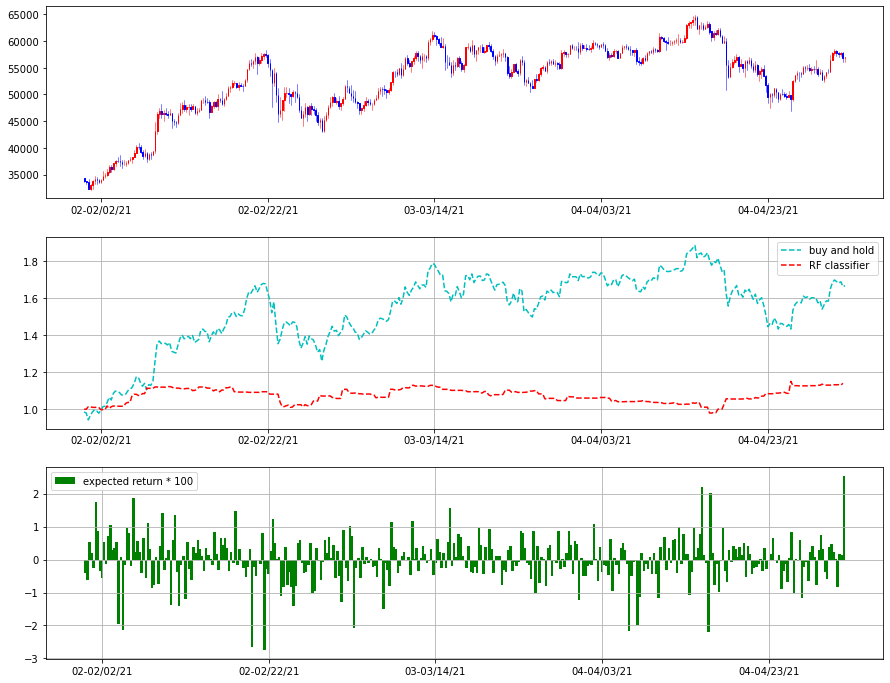

In [18]:
# let's see how the data looks like
ohlc = train_sample[['number', 'open', 'high', 'low', 'close']].copy()

plt.figure(figsize=(15, 12))
p1 = plt.subplot(3, 1, 1)
candlestick_ohlc(p1, ohlc.values, width=0.06, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))

p2 = plt.subplot(3, 1, 2)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.plot(train_sample.number, train_sample.acc_rtn, 'c--', label="buy and hold")
plt.plot(train_book.number, train_book.acc_rtn, 'r--', label='RF classifier')
plt.legend(loc='best')
plt.grid(True)

p3 = plt.subplot(3, 1, 3)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.bar(train_book.number, train_book.weight, color='g', width=0.3, label="expected return * 100")
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [19]:
# evaluate
CAGR = test_sample['acc_rtn'].iloc[-1]**(365*4/len(test_sample.index)) - 1.
historical_max = test_sample['acc_rtn'].cummax()
daily_drawdown = test_sample['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(test_sample['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(test_sample['rtn'])/np.std(test_sample['rtn']))*np.sqrt(365*4)

print("==== Buy and hold ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}ß%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

CAGR = test_book['acc_rtn'].iloc[-1]**(365*4/len(test_book.index)) - 1.
historical_max = test_book['acc_rtn'].cummax()
daily_drawdown = test_book['acc_rtn']/historical_max - 1.
historical_dd = daily_drawdown.cummin()
MDD = historical_dd.min()
VOL = np.std(test_book['rtn'])*np.sqrt(365*4)
Sharpe = (np.mean(test_book['rtn'])/np.std(test_book['rtn']))*np.sqrt(365*4)

print("==== RF Classifier ====")
print(f"CAGR: {round(CAGR*100, 2)}%")
print(f"MDD: {round(MDD*100, 2)}%")
print(f"VOL: {round(VOL*100, 2)}%")
print(f"Sharpe: {round(Sharpe*100, 2)}%")

==== Buy and hold ====
CAGR: -99.45%
MDD: -44.61%
VOL: 116.88ß%
Sharpe: -385.88%
==== RF Classifier ====
CAGR: 26.69%
MDD: -4.76%
VOL: 26.28%
Sharpe: 103.15%


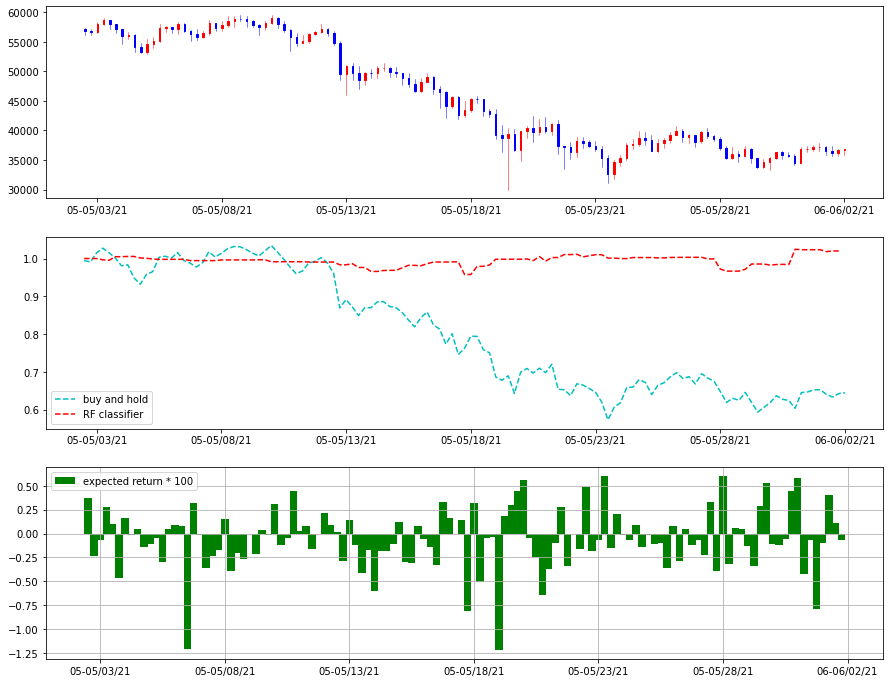

In [20]:
# let's see how the data looks like
ohlc = test_sample[['number', 'open', 'high', 'low', 'close']].copy()

plt.figure(figsize=(15, 12))
p1 = plt.subplot(3, 1, 1)
candlestick_ohlc(p1, ohlc.values, width=0.06, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))

p2 = plt.subplot(3, 1, 2)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.plot(test_sample.number, test_sample.acc_rtn, 'c--', label="buy and hold")
plt.plot(test_book.number, test_book.acc_rtn, 'r--', label='RF classifier')
plt.legend(loc='best')

p3 = plt.subplot(3, 1, 3)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))
plt.bar(test_book.number, test_book.weight, color='g', width=0.3, label="expected return * 100")
plt.legend(loc='best')
plt.grid(True)
plt.show()